https://romanorac.github.io/cryptocurrency/analysis/2017/12/17/cryptocurrency-analysis-with-python-part1.html
https://romanorac.github.io/cryptocurrency/analysis/2017/12/25/cryptocurrency-analysis-with-python-part2.html

In [3]:
from_symbol = 'BTC'
to_symbol = 'USD'
exchange = 'Bitstamp'
datetime_interval = 'day'

In [4]:
import requests
from datetime import datetime


def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)


def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals

    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)

    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data


def convert_to_dataframe(data):
    df = pd.io.json.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df


def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df



Filtering 712 empty datapoints
Saving data to BTC_USD_Bitstamp_day_2018-06-08.csv


In [17]:
from_symbol = 'LTC'


In [18]:

data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

Filtering 1652 empty datapoints
Saving data to LTC_USD_Bitstamp_day_2018-06-08.csv


In [5]:
import pandas as pd

def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

df = read_dataset(filename)

Reading data from BTC_USD_Bitstamp_day_2018-06-08.csv
(1289, 6)


In [9]:
from stockstats import StockDataFrame
df = StockDataFrame.retype(df)
df['macd'] = df.get('macd') # calculate MACD

In [10]:
df.head()


,low,high,open,close,volumefrom,volumeto,close_12_ema,close_26_ema,macd,macds,macdh
datetime,,,,,,,,,,,
2014-11-28,360.57,381.34,363.59,376.28,8617.15,3220878.18,376.280000,376.280000,0.000000,0.000000,0.000000
2014-11-29,372.25,386.60,376.42,376.72,7245.19,2746157.05,376.518333,376.508462,0.009872,0.005484,0.008775
2014-11-30,373.32,381.99,376.57,373.34,3046.33,1145566.61,375.277829,375.370064,-0.092235,-0.034565,-0.115341
2014-12-01,373.03,382.31,376.40,378.39,6660.56,2520662.37,376.260220,376.214306,0.045914,-0.007302,0.106432
2014-12-02,375.23,382.86,378.39,379.25,6832.53,2593576.46,377.072532,376.918296,0.154236,0.040752,0.226969


In [11]:
from math import pi

from bokeh.plotting import figure, show, output_notebook, output_file
output_notebook()

datetime_from = '2016-01-01 00:00'
datetime_to = '2017-12-10 00:00'


def get_candlestick_width(datetime_interval):
    if datetime_interval == 'minute':
        return 30 * 60 * 1000  # half minute in ms
    elif datetime_interval == 'hour':
        return 0.5 * 60 * 60 * 1000  # half hour in ms
    elif datetime_interval == 'day':
        return 12 * 60 * 60 * 1000  # half day in ms


df_limit = df[datetime_from: datetime_to].copy()
inc = df_limit.close > df_limit.open
dec = df_limit.open > df_limit.close

title = '%s datapoints from %s to %s for %s and %s from %s with MACD strategy' % (
    datetime_interval, datetime_from, datetime_to, from_symbol, to_symbol, exchange)
p = figure(x_axis_type="datetime",  plot_width=1000, title=title)

p.line(df_limit.index, df_limit.close, color='black')

# plot macd strategy
p.line(df_limit.index, 0, color='black')
p.line(df_limit.index, df_limit.macd, color='blue')
p.line(df_limit.index, df_limit.macds, color='orange')
p.vbar(x=df_limit.index, bottom=[
       0 for _ in df_limit.index], top=df_limit.macdh, width=4, color="purple")

# plot candlesticks
candlestick_width = get_candlestick_width(datetime_interval)
p.segment(df_limit.index, df_limit.high,
          df_limit.index, df_limit.low, color="black")
p.vbar(df_limit.index[inc], candlestick_width, df_limit.open[inc],
       df_limit.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df_limit.index[dec], candlestick_width, df_limit.open[dec],
       df_limit.close[dec], fill_color="#F2583E", line_color="black")

output_file("visualizing_trading_strategy.html", title="visualizing trading strategy")
show(p)

Loading BokehJS ...

In [13]:
import pandas as pd

def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)

def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

In [23]:
df_btc = read_dataset(get_filename('BTC', 'USD', 'Bitstamp', 'day', '2018-06-08'))
df_eth = read_dataset(get_filename('ETH', 'USD', 'Bitstamp', 'day', '2018-06-08'))
df_ltc = read_dataset(get_filename('LTC', 'USD', 'Bitstamp', 'day', '2018-06-08'))

Reading data from BTC_USD_Bitstamp_day_2018-06-08.csv
(1289, 6)
Reading data from ETH_USD_Bitstamp_day_2018-06-08.csv
(212, 6)
Reading data from LTC_USD_Bitstamp_day_2018-06-08.csv
(349, 6)


In [37]:
df = pd.DataFrame({'BTC': df_btc.close,
                   'ETH': df_eth.close,
                   'LTC': df_ltc.close})

In [38]:
df.head()


,BTC,ETH,LTC
datetime,,,
2014-11-28,376.28,NaN,NaN
2014-11-29,376.72,NaN,NaN
2014-11-30,373.34,NaN,NaN
2014-12-01,378.39,NaN,NaN
2014-12-02,379.25,NaN,NaN


In [39]:
df.describe()


,BTC,ETH,LTC
count,1289.000000,212.000000,349.000000
mean,2539.676905,691.064811,120.538138
std,3776.209463,236.832866,72.964888
min,162.000000,298.660000,38.100000
25%,328.300000,503.455000,54.270000
50%,635.690000,685.480000,117.220000
75%,2740.000000,842.027500,164.130000
max,19187.780000,1384.780000,357.120000


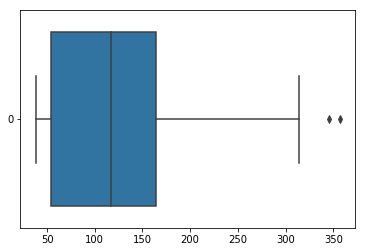

In [40]:
import seaborn as sns

ax = sns.boxplot(data=df['LTC'], orient="h")

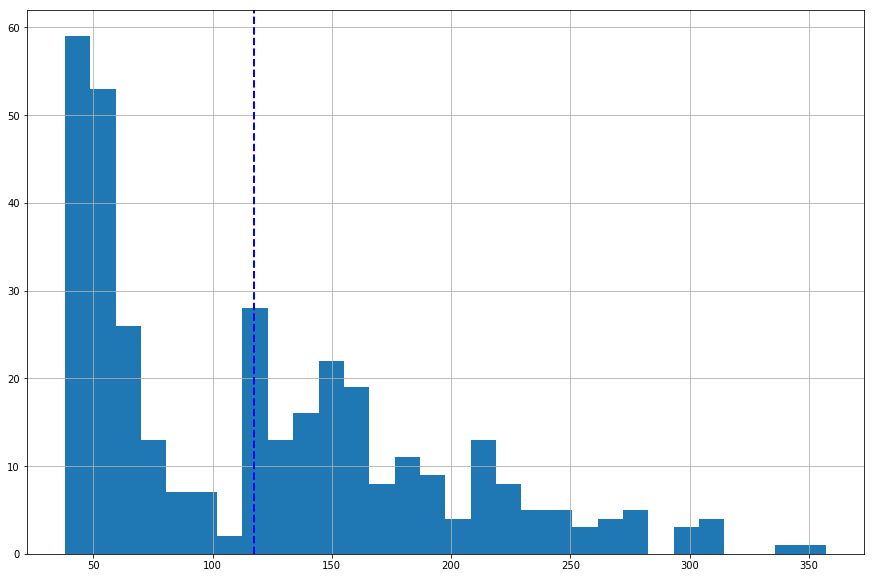

In [41]:
df['LTC'].hist(bins=30, figsize=(15,10)).axvline(df['LTC'].median(), color='b', linestyle='dashed', linewidth=2)


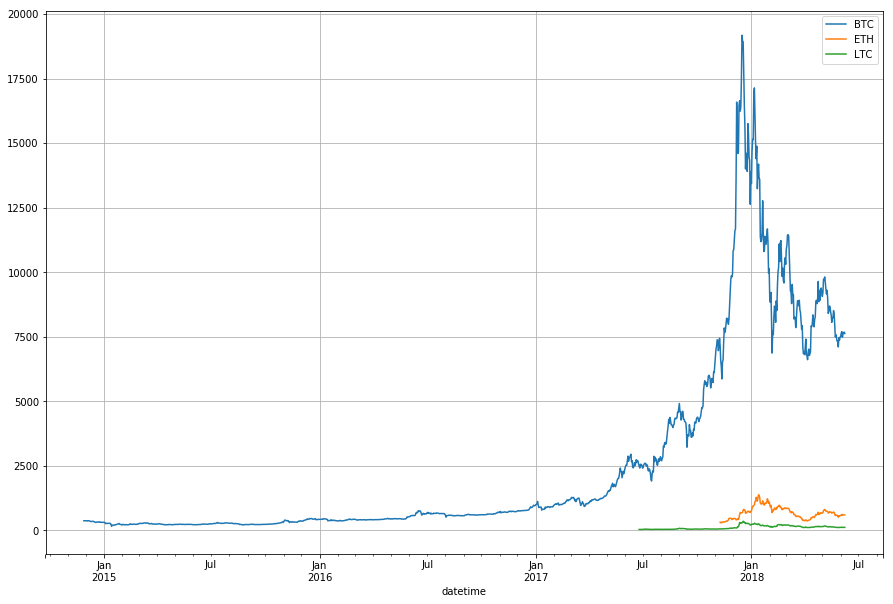

In [42]:
df.plot(grid=True, figsize=(15, 10))


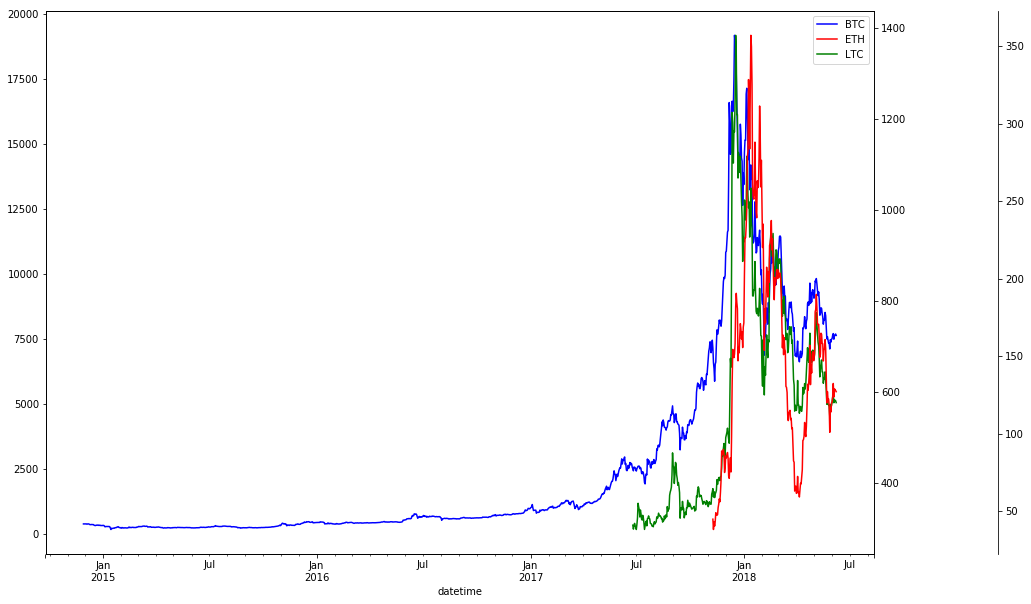

In [43]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.15))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

df['BTC'].plot(ax=ax1, style='b-')
df['ETH'].plot(ax=ax1, style='r-', secondary_y=True)
df['LTC'].plot(ax=ax2, style='g-')

# legend
ax2.legend([ax1.get_lines()[0],
            ax1.right_ax.get_lines()[0],
            ax2.get_lines()[0]],
           ['BTC', 'ETH', 'LTC'])

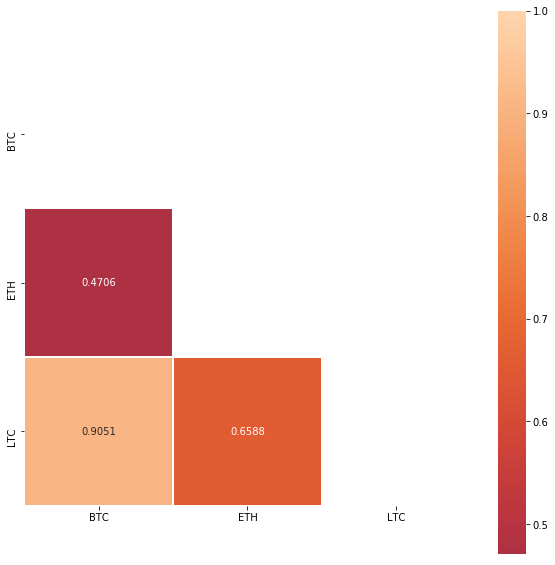

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

In [54]:
df2=df.dropna()
df_return = df2.apply(lambda x: x / x[0])
df_return.head()

,BTC,ETH,LTC
datetime,,,
2017-11-09,1.000000,1.000000,1.000000
2017-11-10,0.921682,0.929478,0.916253
2017-11-11,0.889078,0.982696,0.968828
2017-11-12,0.821260,0.952633,0.910360
2017-11-13,0.912867,0.983879,0.946495


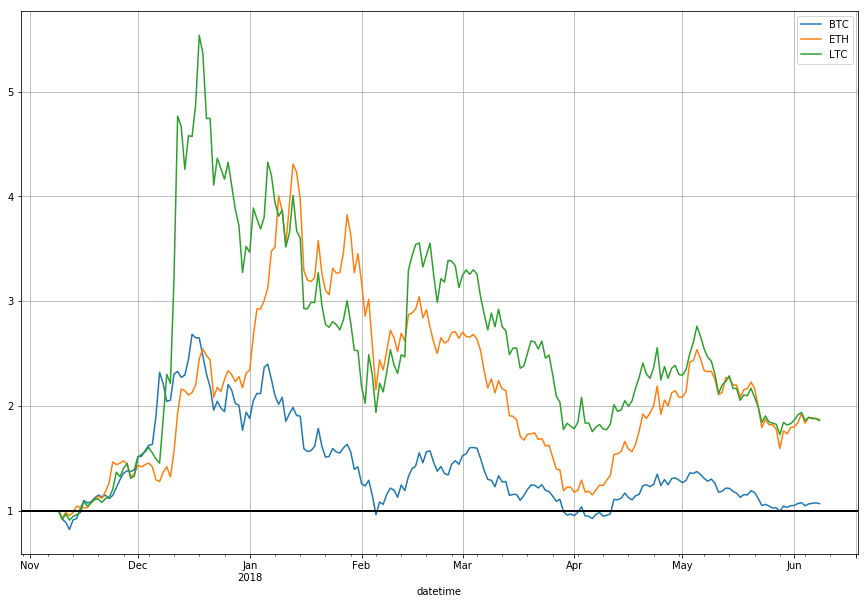

In [55]:
df_return.plot(grid=True, figsize=(15, 10)).axhline(y = 1, color = "black", lw = 2)


,BTC,ETH,LTC
datetime,,,
2018-06-08,106.768607,187.202788,186.08871


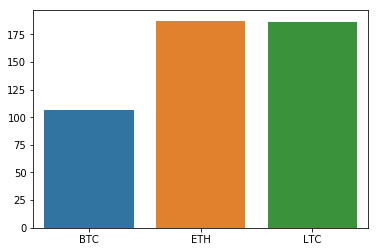

In [56]:
df_perc = df_return.tail(1) * 100
ax = sns.barplot(data=df_perc)
df_perc

,BTC,ETH,LTC
datetime,,,
2017-11-09,0.139899,3.112162,15.508685


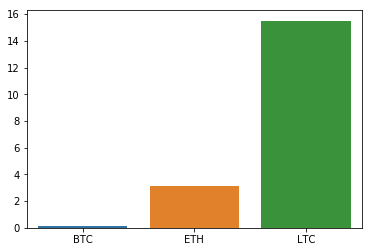

In [58]:
budget = 1000 # USD
df_coins = budget/df2.head(1)

ax = sns.barplot(data=df_coins)
df_coins